In [1]:
import pandas as pd
import numpy as np
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from ipywidgets import interact

# get a list of all the colour strings in matplotlib so we can iterate through them
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colour_list = list(colors.keys())
# 9 base colours ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'aliceblue', 'antiquewhite', 'aqua'...

# Read in Iteration Data (Training and NNet)

Does all of the ugly calculations. Note, when the actions are changed, only self.action_space needs to be changed.

In [22]:
class IterationData:
    """
    A class to load in the data from each iteration to an object in a readable form for later visualisation    
    """
    def __init__(self, folder_path, iteration):

        self.training_path = folder_path + 'TrainingExamples' + str(iteration)
        self.nnet_loss_path = folder_path + 'NNetLosses' + str(iteration)
        
        # data formatting
        self.decimal_places = 3
        self.csv_rows = 7
        self.action_space = [-1, 1]
        
        # data manipulation
        self.x_threshold = 2.4
        self.theta_threshold_radians = 0.21
        
        # define a useful class for training examples, so we can access dict memebers as .'key' rather than ['key']
        class ReturnClass(dict):
            def __getattr__(self, name):
                return self[name]
        
        # just get the number of episodes (need to do this before adding episodes to the dict annoyingly)
        with open(self.training_path + '.csv', 'r', newline='') as f:
            row_count = sum(1 for row in f)
        self.episodes = int(row_count/self.csv_rows)
        
        # read in training examples data and nnet loss data
        # dict of {ep1: dataframe[2Dstate, TrueValue, PolicyValue, MCTSAction, PolicyAction, Observation], ep2: ...}
        self.episode_data = ReturnClass()
        self.all_data = pd.DataFrame(columns=['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'MCTSAdv', 'PolicyAdv' ,'Observation', 'State2D'])
        self.state_2ds = np.load(self.training_path +'.npz')
        self.read_examples()
        self.nnet_losses = self.read_nnet_losses()
    
    def read_examples(self):
        step_counter = 0
        for episode in range(self.episodes):
            
            rows = [self.csv_rows*episode+x for x in range(self.csv_rows)]

            # only pick out relevent rows (because others are different lengths -> can't be read)
            episode_data = pd.read_csv(self.training_path + '.csv', header=None, skiprows=lambda x: x not in rows).transpose()
            episode_data.columns = ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'MCTSAdv', 'PolicyAdv', 'Observation']
            episode_data.TrueValue = episode_data.TrueValue.astype(float).round(self.decimal_places)
            episode_data.PolicyValue = episode_data.PolicyValue.astype(float).round(self.decimal_places)

            # Split arrays and convert to floats
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.MCTSAction = episode_data.MCTSAction.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
            
            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: x[1:-1].split(', '))
            episode_data.PolicyAction = episode_data.PolicyAction.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
        
            episode_data.MCTSAdv = episode_data.MCTSAdv.apply(lambda x: x[1:-1].split(', '))
            episode_data.MCTSAdv = episode_data.MCTSAdv.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
            
            episode_data.PolicyAdv = episode_data.PolicyAdv.apply(lambda x: x[1:-1].split(', '))
            episode_data.PolicyAdv = episode_data.PolicyAdv.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])
            
            episode_data.Observation = episode_data.Observation.apply(lambda x: x[1:-1].split())
            episode_data.Observation = episode_data.Observation.apply(lambda x: [round(float(elm), self.decimal_places) for elm in x])

            # if we want extra columns then this is the way to seperate the arr
            # print(list(zip(*dataframe.MCTSAction.values)))            
            
            # add a reference to the stated2D for each step
            episode_states = list(self.state_2ds)[step_counter:step_counter+episode_data.index[-1]+1]
            step_counter += episode_data.index[-1]+1          
            episode_data['State2D'] = episode_states
            
            # and then add the whole dataframe to the dict
            self.episode_data['Episode'+str(episode)] = episode_data
            self.all_data = pd.concat([self.all_data, episode_data], ignore_index=True)
        
    def read_nnet_losses(self):
        losses = pd.read_csv(self.nnet_loss_path + '.csv', names=['PlayerAction', 'AdversaryAction', 'Value', 'Total'])
        return losses
    
    def get_state_2d(self, episode, step):
        episode = 'Episode'+str(episode)
        return self.state_2ds[self.episode_data[episode].State2D.values[step]]
    
    def get_episode_length(self, episode):
        episode = 'Episode'+str(episode)
        return self.episode_data[episode].index[-1]
    
    def get_max_episode(self):
        max_ep_len, max_ep = 0, 0
        for ep in range(self.episodes):
            ep_len = self.get_episode_length(ep)
            if ep_len > max_ep_len:
                max_ep_len = ep_len
                max_ep = ep
        return max_ep

In [23]:
folder = os.path.join('..\Cartpole', 'Data\\')
iter_data = IterationData(folder, iteration=0)
iter_data.episode_data['Episode0'].tail()

,TrueValue,PolicyValue,MCTSAction,PolicyAction,MCTSAdv,PolicyAdv,Observation,State2D
4,-0.397,-0.477,"[0.5, 0.5]","[0.476, 0.524]","[0.5, 0.5]","[0.451, 0.549]","[-0.076, 1.085, -0.086, -1.564]",arr_4
5,-0.496,-0.474,"[0.667, 0.333]","[0.484, 0.516]","[0.394, 0.606]","[0.458, 0.542]","[-0.054, 0.883, -0.117, -1.354]",arr_5
6,-0.679,-0.471,"[0.688, 0.312]","[0.492, 0.508]","[0.594, 0.406]","[0.465, 0.535]","[-0.036, 0.681, -0.145, -1.158]",arr_6
7,-0.795,-0.476,"[0.533, 0.467]","[0.48, 0.52]","[0.4, 0.6]","[0.461, 0.539]","[-0.023, 0.88, -0.168, -1.766]",arr_7
8,-0.977,-0.473,"[0.533, 0.467]","[0.488, 0.512]","[0.567, 0.433]","[0.468, 0.532]","[-0.005, 0.679, -0.203, -1.594]",arr_8


In [24]:
iter_data.all_data.tail()

,TrueValue,PolicyValue,MCTSAction,PolicyAction,MCTSAdv,PolicyAdv,Observation,State2D
880,-0.335,-0.465,"[0.7, 0.3]","[0.509, 0.491]","[0.633, 0.367]","[0.49, 0.51]","[-0.236, 0.103, -0.133, -1.143]",arr_880
881,-0.404,-0.463,"[0.725, 0.275]","[0.517, 0.483]","[0.6, 0.4]","[0.497, 0.503]","[-0.234, -0.098, -0.156, -0.955]",arr_881
882,-0.518,-0.460,"[0.767, 0.233]","[0.524, 0.476]","[0.581, 0.419]","[0.504, 0.496]","[-0.236, -0.299, -0.175, -0.778]",arr_882
883,-0.708,-0.457,"[0.762, 0.238]","[0.532, 0.468]","[0.452, 0.548]","[0.511, 0.489]","[-0.242, -0.499, -0.191, -0.611]",arr_883
884,-0.977,-0.460,"[0.5, 0.5]","[0.522, 0.478]","[0.607, 0.393]","[0.504, 0.496]","[-0.252, -0.292, -0.203, -0.934]",arr_884


In [25]:
print("GOOD get_state_2d(episode, step): ", iter_data.get_state_2d(episode=0, step=1))
print("BAD state_2ds[\'arr_x\']: ", iter_data.state_2ds['arr_200'])

GOOD get_state_2d(episode, step):  [-0.14112279  0.88755037 -0.00631009 -0.97641988]
BAD state_2ds['arr_x']:  [ 0.74887657 -0.61474158 -0.02561481  0.38868333]


# Class To Visualise a Single Iteration

Generally these don't go quite as far as plotting, they create and return an axes object, which can then be plotted, or used in the Visualise class, which compares iterations

In [34]:
class VisualiseIteration():
    """
    Uses objects of IterationData, which contians methods to easily access data, summarised below:
        
    Attributes:
        self.episodes = number of episodes in an iteration
        self.nnet_losses = Dataframe with ['PlayerAction', 'AdversaryAction', 'Value', 'Total'] as the column headders
        self.episode_data = A Dictionary of episodes with keys ['EpisodeN'] where N is an int.
                Each episode's value is a pandas dataframe with columns:

    ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'MCTSAdv', 'PolicyAdv',  'Observation',      'State2D']
      [ float,      float,         [f, f],        [f, f],      [f, f],     [f, f],  [x, xdot, theta, thetadot], 'arr_n']
    
        self.all_data = all of the episode data joined in columns as above
    
    Methods:
        get_state_2d(self, episode, step)
        get_episode_length(self, episode)
        get_max_episode(self)
    """
    
    def __init__(self, folder_path, iteration):
        
        self.iter = iteration
        self.action_space = [-1, 1]  # [left, right]
        self.action_names ={0: 'Left', 1: 'Right'}
        self.default_action = 0  # left is default action to show (no need to show left and right)
        self.iter_data = IterationData(folder_path, iteration)
        
        self.x_threshold = self.iter_data.x_threshold
        self.theta_threshold_radians = self.iter_data.theta_threshold_radians
        
    
    def add_axis_valuevsstep(self, episode=None, colour = 'blue', axes=None):
        # extract data for values and actions
        if episode is None:
            episode = self.iter_data.get_max_episode()
        policy_values = self.iter_data.episode_data['Episode'+str(episode)].PolicyValue
        true_values = self.iter_data.episode_data['Episode'+str(episode)].TrueValue
        
        # check if subplots already exist
        if axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))
            
        # Value Subplot
        axes.plot(policy_values, color=colour, linestyle='--', label='Policy Values, Iter:'+str(self.iter)+ ' Ep:'+str(episode))
        axes.plot(true_values, color=colour, linestyle='-', label='True Values, Iter:'+str(self.iter)+ ' Ep:'+str(episode))
        axes.legend()
        axes.set_ylabel('State Value')
        
        return axes
    
    def add_axis_actionvsstep(self, episode=None, agent='player', colour = 'blue', axes=None):
        
        assert agent == 'player' or agent == 'adversary' or agent == 'both', 'Not a valid agent'
        if episode is None:
            episode = self.iter_data.get_max_episode()
            
        if agent == 'player' or agent == 'both':
            policy_actions = self.iter_data.episode_data['Episode'+str(episode)].PolicyAction.values
            mcts_actions = self.iter_data.episode_data['Episode'+str(episode)].MCTSAction.values
        else:
            policy_actions = self.iter_data.episode_data['Episode'+str(episode)].PolicyAdv.values
            mcts_actions = self.iter_data.episode_data['Episode'+str(episode)].MCTSAdv.values
            
        policy_actions = list(zip(*policy_actions))[self.default_action]
        mcts_actions = list(zip(*mcts_actions))[self.default_action]   

        # check if subplots already exist
        rows = 2 if agent == 'both' else 1
        if axes is None:
            fig, axes = plt.subplots(ncols=1, nrows=rows, figsize=(17, rows*7))
        axes1 = axes[0] if agent=='both' else axes
        
        axes1.plot(policy_actions, color=colour, linestyle='--', label='Policy {:s} Actions, Iter: {} Ep: {}'.format(agent, self.iter, episode))
        axes1.plot(mcts_actions, color=colour, linestyle='-', label='MCTS {:s} Actions, Iter: {} Ep: {}'.format(agent, self.iter, episode))
        axes1.legend()
        axes1.set_ylabel(self.action_names[self.default_action]+' probability')
        axes1.set_xlabel('Steps')
        
        if agent == 'both':
            axes2 = axes[1]
            policy_adv = self.iter_data.episode_data['Episode'+str(episode)].PolicyAdv.values
            mcts_adv = self.iter_data.episode_data['Episode'+str(episode)].MCTSAdv.values
            
            policy_adv = list(zip(*policy_adv))[self.default_action]
            mcts_adv = list(zip(*mcts_adv))[self.default_action]  
            
            axes2.plot(policy_adv, color=colour, linestyle='--', label='Policy {} Actions, Iter: {} Ep: {}'.format(agent, self.iter, episode))
            axes2.plot(mcts_adv, color=colour, linestyle='-', label='MCTS {} Actions, Iter: {} Ep: {}'.format(agent, self.iter, episode))
            axes2.legend()
            axes2.set_ylabel(self.action_names[self.default_action]+' probability')
            axes2.set_xlabel('Steps')
            axes1 = [axes1, axes2]

        return axes1
        
    def get_episode_value_stats(self):
        averages = -1*np.ones((200+1, ))
        deviations = np.zeros((200+1, ))
        all_episodes = []
        # print(averages.head())
        for ep in range(self.iter_data.episodes):
            true_values = self.iter_data.episode_data['Episode'+str(ep)].TrueValue.values  # TrueValue or PolicyValue
            all_episodes.append(true_values)
            x = self.iter_data.get_episode_length(ep)+1
            averages[0:x] += true_values
            averages[x:] += -1
            deviations[0:x] += true_values**2
            deviations[x:] += 1
        
        averages = averages/self.iter_data.episodes
        deviations = np.sqrt(deviations - averages**2)/self.iter_data.episodes  # to get the standard deviation
        return averages, deviations, all_episodes
                  
    def plot_observations_histogram(self, normalised=True):
        
        all_observations = self.iter_data.all_data['Observation'].values
            
        # normalise all the observations
        if normalised:
            all_normed_observations = []
            for step in all_observations:
                obs = [step[0]/self.x_threshold,
                        step[1]/self.x_threshold,
                        step[2]/self.theta_threshold_radians,
                        step[3]/self.theta_threshold_radians,
                        ]
                all_normed_observations.append(obs)
            all_observations = all_normed_observations
        # flip the dimensions
        all_observations = list(zip(*all_observations))
        
        # Plot histograms
        fig, axes = plt.subplots(ncols=len(all_observations), nrows=1, figsize=(len(all_observations)*5, 5))
        obs_label = ['x', '$\dot{x}$', '$\\theta$', '$\dot{\\theta}$']
        axes[0].set_ylabel('Probability of Observation')
        for dim in range(len(all_observations)):
            axes[dim].hist(all_observations[dim], bins=20, density=True, color=colour_list[dim], alpha=0.9)
            if normalised:
                axes[dim].set_xlabel('Normalised '+obs_label[dim])
            else:
                axes[dim].set_xlabel(obs_label[dim])
    
    def get_actionvsstate_probs(self, policy, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.15):
                      
        shape = self.iter_data.get_state_2d(episode=0, step=0).shape
        x_dot_bin_size = bin_proportion # /self.x_threshold # either side of the value
        theta_dot_bin_size = bin_proportion # /self.theta_threshold_radians # either side of the value
        
        # only 2 actions currently
        player_probs = np.zeros(shape, dtype=float)
        player_counter = np.zeros(shape, dtype=float)
        adv_probs = np.zeros(shape, dtype=float)
        adv_counter = np.zeros(shape, dtype=float)
        
        if policy:
            player_act = 'PolicyAction'
            adv_act = 'PolicyAdv'
        else:
            player_act = 'MCTSAction'
            adv_act = 'MCTSAdv'
            
        player_actions = list(zip(*self.iter_data.all_data[player_act].values))[self.default_action]
        adv_actions = list(zip(*self.iter_data.all_data[adv_act].values))[self.default_action]
                  
        obs = list(zip(*self.all_data['Observation'].values))
        state_2ds = self.iter_data.all_data['State2D'].values
        obs0, obs1, obs2, obs3 = np.array(obs[0]), np.array(obs[1]), np.array(obs[2]), np.array(obs[3])
        
        is_near_x_dot = (obs1 > x_dot_fixed - x_dot_bin_size) & (obs1 < x_dot_fixed + x_dot_bin_size)
        is_near_theta_dot = (obs3 > theta_dot_fixed - theta_dot_bin_size) & (obs3 < theta_dot_fixed + theta_dot_bin_size)
        filtered_player = np.array(player_actions)[is_near_x_dot & is_near_theta_dot]
        filtered_adv = np.array(adv_actions)[is_near_x_dot & is_near_theta_dot]
        filtered_states = np.array(state_2ds)[is_near_x_dot & is_near_theta_dot]
        
        for idx, step in enumerate(filtered_states):
            state_2d = self.state_2ds[step]
            row, column = np.unravel_index(np.argmax(state_2d, axis=None), shape) # get the index of the current element
            
            player_probs[row, column] += filtered_player[idx]
            player_counter[row, column] += 1
                  
            adv_probs[row, column] += filtered_adv[idx]
            adv_counter[row, column] += 1
            
        player_probs = np.true_divide(player_probs, player_counter)
        adv_probs = np.true_divide(adv_probs, adv_counter)   
        return player_probs, adv_probs
    
    def add_axis_actionprobvsstate(self, prob_array, axes, agent='player', vs=(0.2, 0.8)):
        
        image = axes.imshow(prob_array, vmin = vs[0], vmax=vs[1], 
                            extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians, self.theta_threshold_radians], 
                            cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title('Probability of '+agent+' Choosing Left vs Position')
    
    def plot_state_2d(self, episode, step):
        # Plot MCTS action, action policy and values associated?
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])  # add an axis object to the figure
        state_2d = self.iter_data.get_state_2d(episode, step)
        
        # returns a colourAxisImage, that we need to map the colourbar to the figure
        mapable = axes.imshow(state_2d, extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                     self.theta_threshold_radians], cmap='jet', aspect='auto')
        axes.set_xlabel("X-Position")
        axes.set_ylabel("Angular Position")
        axes.set_title('The 2D State')

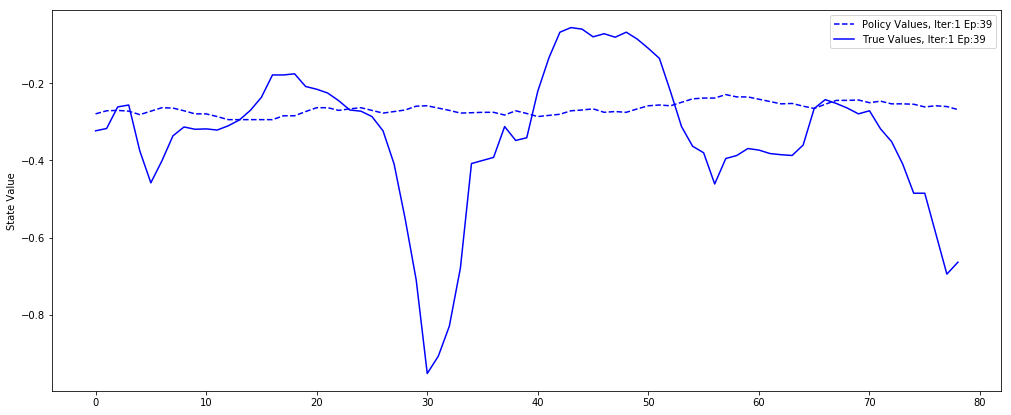

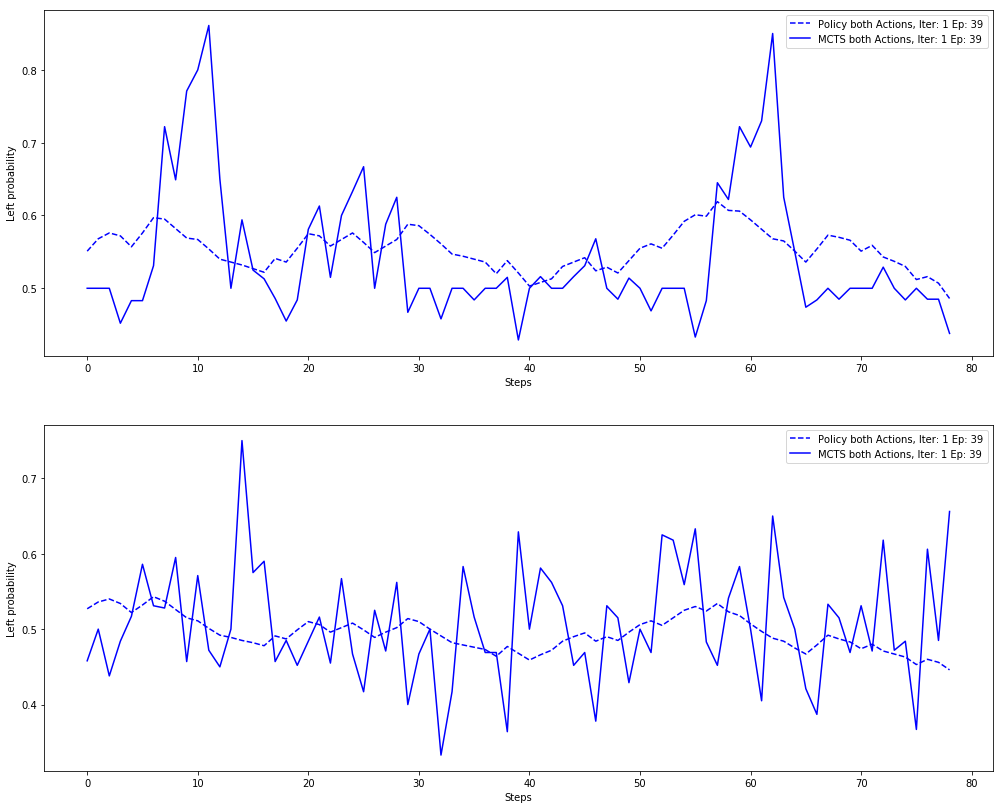

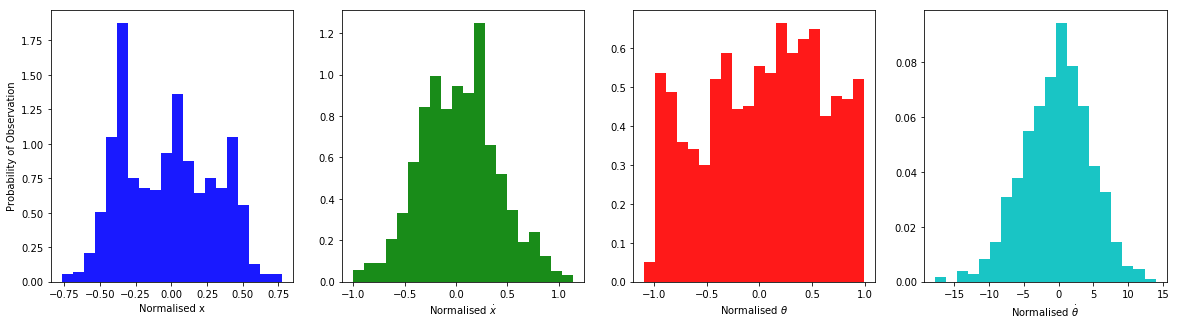

In [35]:
folder = os.path.join('..\Cartpole', 'Data\\')
iter_vis = VisualiseIteration(folder, 1)
iter_vis.add_axis_valuevsstep(None, colour = 'blue', axes=None)
iter_vis.add_axis_actionvsstep(None, agent='both', colour = 'blue', axes=None)
iter_vis.get_episode_value_stats()
iter_vis.plot_observations_histogram(normalised=True)

In [86]:
class VisualiseIterations:
    """
    VisualiseIterations principally contains a list of VisualiseIteration objects, which in turn contain Iteration data objects
    leading to an objects hirachy of VisualiseIterations <- Iter*VisualiseIteration <- IterationData. The main components of
    the two attribute classes are shown below:
    
    VisualiseIterations:
    Attributes:
        self.iters_data = [iter_data0, iter_data1, iter_data2, ...]
        self.iterations
    
    VisualiseIteration:
    Attributes:
        self.iter, self.action_space = [-1, 1], self.action_names ={0: 'Left', 1: 'Right'}
        self.default_action = 0  # left is default action to show (no need to show left and right)
        iter_data = IterationData(folder_path, iteration)       
    Methods:
        add_axis_valuevsstep(self, episode=None, colour = 'blue', axes=None)
        add_axis_actionvsstep(self, episode=None, agent='player', colour = 'blue', axes=None)
        get_episode_value_stats(self)
        plot_observations_histogram(self, normalised=True)
        get_actionvsstate_probs(self, policy, x_dot_fixed=0, theta_dot_fixed=0, bin_proportion=0.15)
        add_axis_actionprobvsstate(self, prob_array, axes, agent='player', vs=(0.2, 0.8))
        plot_state_2d(self, episode, step)
    
    IterationData:
    Attributes:
        self.episodes = number of episodes in an iteration
        self.nnet_losses = Dataframe with ['PlayerAction', 'AdversaryAction', 'Value', 'Total'] as the column headders
        self.episode_data = A Dictionary of episodes with keys ['EpisodeN'] where N is an int.
                Each episode's value is a pandas dataframe with columns:

    ['TrueValue', 'PolicyValue', 'MCTSAction', 'PolicyAction', 'MCTSAdv', 'PolicyAdv',  'Observation',      'State2D']
      [ float,      float,         [f, f],        [f, f],      [f, f],     [f, f],  [x, xdot, theta, thetadot], 'arr_n']
    
        self.all_data = all of the episode data joined in columns as above
    
    Methods:
        get_state_2d(self, episode, step)
        get_episode_length(self, episode)
        get_max_episode(self)
    """
    def __init__(self, data_set_path, iters='all'):
        self.folder_path = data_set_path

        self.iters_data = []
        if iters == 'all':
            self.iterations = 0
            while True:
                try: self.iters_data.append(VisualiseIteration(self.folder_path, self.iterations))
                except: break
                self.iterations += 1
        else:
            assert isinstance(iters, list)
            for itr in iters:
                self.iters_data.append(VisualiseIteration(self.folder_path, itr))
            self.iterations = len(self.iters_data)
            
        print("There are ", self.iterations, " iterations stored in self.iterations")
            
    def plot_valuevsstep(self, iters=[0, 1, 2], plot_stds=False, plot_all_eps=False):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"
        
        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        axes.set_xlabel('Steps')
        axes.set_ylabel('Average Value')
        axes.set_ylim([-1, 0])
        for itr in iters:
            means, std, all_eps = self.iters_data[itr].get_episode_value_stats()
            
            axes.plot(means, linestyle='-', color=colour_list[itr], label='Itr:'+str(itr)+' Average Episode Value')
            if plot_stds:
                axes.plot(means+std, linestyle='--', color=colour_list[itr], label=None)
                axes.plot(means-std, linestyle='--', color=colour_list[itr], label=None)
            if plot_all_eps:
                for i in range(self.iters_data[itr].iter_data.episodes):
                    axes.plot(all_eps[i], linestyle=':', label=None)
                    
            axes.legend()
            
    def plot_nnet_lossesvsbatch(self, iters=[0, 1, 2]):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"
        
        fig = plt.figure(figsize=(17, 7))
        axes = fig.add_axes([0, 0, 1, 1])
        
        axes.set_xlabel('Batches (size 8)')
        axes.set_ylabel('Loss')
        
        for itr in iters:
            axes.plot(self.iters_data[itr].iter_data.nnet_losses)    
            axes.legend(['Itr '+str(itr)+' Player Action', 'Itr '+str(itr)+' Adversary Action', 'Itr '+str(itr)+' Value', 'Itr '+str(itr)+' Total'])
    
    def plot_observation_histograms(self, iters=[0, 1, 2], normed=True):
        for itr in iters:
            self.iters_data[itr].histogram_observations(normed)
            
    def plot_valuesvssteps(self, iters=[0, 1, 2], episodes='longest'):
        # fig, ax = te0.plot_episode(episode=3, colour='blue')
        max_eps = []
        for itr in iters:
            if episodes == 'longest':
                max_eps.append(self.iters_data[itr].get_max_episode())
            if isinstance(episodes, list):
                pass
        
        # keep plotting iterations on the same axis
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(17, 7))
        for idx, itr in enumerate(iters):
            ax = self.iters_data[itr].add_axis_valuevsstep(max_eps[idx], itr, colour_list[idx], ax)
                                                                  
    def plot_actionsvssteps(self, iters=[0, 1, 2], episodes='longest'):
        max_eps = []
        for itr in iters:
            if episodes == 'longest':
                max_eps.append(self.iters_data[itr].get_max_episode())
            if isinstance(episodes, list):
                pass
        # plot those episodes, one for the player and one for the adversary
        fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(17, 2*7))
        for idx, itr in enumerate(iters):
            ax = self.iters_data[itr].add_axis_actionvsstep(max_eps[idx], itr, actions, colour_list[idx], ax)
            
    def plot_actionprobsvsstates(self, iters=[0, 1, 2], policy=True, x_dot_fixed=0, theta_dot_fixed=0, bin_prop=0.05, colourbar_lims=(0, 1)):
        assert all(i < self.iterations for i in iters), "Some iterations are not valid!"

        for itr in iters:
            player_probs, adversary_probs = self.iters_data[itr].get_actionvsstate_probs(policy, x_dot_fixed, theta_dot_fixed, bin_prop)

            # Plot the things
            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17, 5), sharey=True)
            self.iters_data[itr].add_axis_actionprobvsstate(player_probs, axes[0], agent='player', vs=colourbar_lims)
            self.iters_data[itr].add_axis_actionprobvsstate(adversary_probs, axes[1], agent='adversary', vs=colourbar_lims)

            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            fig.colorbar(im, cax=cbar_ax)        
        
    def vs_state_3d(self, data_set='PolicyAction', iteration=0, angle=45, omitted_state='x_dot', omitted_state_value=0, binsize=0.15):
        
        cmap = 'viridis' if data_set in ['PolicyAction', 'PolicyAdv', 'PolicyValue'] else 'plasma' 
        colour_ttl = 'State Value' if data_set in ['PolicyValue', 'TrueValue'] else 'Probability of \n the Agent Pushing Left'
        non_omitted_state_idx = 1 if omitted_state == 'theta_dot' else 3
        itr = iteration
        
        try:
            # print(self.iters_data[itr], self.iters_data[itr].iter_data)
            action_or_value = list(zip(*self.iters_data[itr].iter_data.all_data[data_set].values))[0]
        except:
            action_or_value = self.iters_data[itr].iter_data.all_data[data_set].values
        obs = list(zip(*self.iters_data[itr].iter_data.all_data['Observation'].values))
        
        # set up the plot    
        fig = plt.figure(figsize=(17, 14))
        ax = fig.add_subplot(111, projection='3d')
        if omitted_state == 'theta_dot':
            omitted_obs = np.array(obs[3])
            ax.set_ylabel('$\dot{x}$, x-velocity (m/s)');
            ax.set_title('Iteration {} {} with $\dot{{\\theta}}$ = {}$\pm${} rad/s'.format(itr, data_set, omitted_state_value, binsize))
           
        else:
            omitted_obs = np.array(obs[1])
            ax.set_ylabel('$\dot{\\theta}$, angular velocity (rad/s)')
            ax.set_title('Iteration {} {} with $\dot{{x}}$ = {}$\pm${} m/s'.format(itr, data_set, omitted_state_value, binsize))
            
            
        x_min, x_max = min((obs[0]))-1, max(obs[0])
        omitted_min, omitted_max = min(omitted_obs)-1, max(omitted_obs) 
        theta_min, theta_max = min(obs[2])-0.25, max(obs[2])
            
            
        # extract the relavent points    
        is_near_filter = (omitted_obs > omitted_state_value-binsize) & (omitted_obs < omitted_state_value+binsize)
        x, y, z = np.array(obs[0])[is_near_filter], np.array(obs[non_omitted_state_idx])[is_near_filter], np.array(obs[2])[is_near_filter]
        density = np.array(action_or_value)[is_near_filter]   
        
        # plot the main plot
        ax.scatter(x, y, z, c=density, alpha=1, cmap=cmap)
        ax.set_xlabel('x position (m)'); ax.set_zlabel('$\\theta$ position (rad)')
        
        # and add the 2d compressed versions
        
        ax.scatter(x, y, theta_min, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        ax.scatter(x_min, y, z, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        ax.scatter(x, omitted_min, z, zdir='z', c=density, s=5, alpha=0.5, cmap=cmap)
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(omitted_min, omitted_max)
        ax.set_zlim(theta_min, theta_max)

        # sort out the colourbar
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        mappable = cm.ScalarMappable(cmap=cmap); mappable.set_array(density); mappable.set_clim(min(action_or_value), max(action_or_value))
        plt.colorbar(mappable, cax=cbar_ax)
        cbar_ax.set_title(colour_ttl)

        
        ax.view_init(25, angle)
        plt.show()

In [87]:
folder = os.path.join('..\Cartpole', 'Data\\')
v = VisualiseIterations(folder, [0, 1, 2])

There are  3  iterations stored in self.iterations


In [89]:
data_set = ['PolicyAction', 'MCTSAction', 'PolicyAdv', 'MCTSAdv', 'PolicyValue', 'TrueValue']
omitted_state = ['x_dot', 'theta_dot']
interact(v.vs_state_3d, data_set=data_set, iteration=(0 , v.iterations-1, 1), angle=(0, 180, 5), omitted_state=omitted_state, omitted_state_value=(-3, 3, 0.1), binsize=(0.05, 2, 0.05))


interactive(children=(Dropdown(description='data_set', options=('PolicyAction', 'MCTSAction', 'PolicyAdv', 'MC…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>